深度學習領域中電腦視覺相關的研究可以說是發展最為快速的一門，可被運用於無人車、視訊監控、人體動作分析等技術，而卷積神經網絡(Convolutional Neural Network, ConvNet, or CNN)可以說是最為重要的技術之一，本文嘗試以最最最淺白的方式講解**基本CNN架構中的一個卷積層是如何運作**。



## 1. Input Graph
- 輸入圖形大小為 $n_H×n_W×n_C$
    - $n_H$、$n_W$為圖形的高和寬
    - $n_C$為圖形的channel(通道)數，彩色圖片的channel數為3(三原色RGB)、灰階圖片channel數則為1

<img src="images/input .jpg">

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

#### 程式中輸入圖片大小為$N×n_H×n_W×n_C$
- 即(張數, 圖高, 圖寬, 通道數)
- 因為需要同時進行多張圖的運算故作調整
- 但以下doge範例中彩色和灰階的張數都是$1 (N=1)$

Shape of doge_rgb = (1, 540, 959, 3)
Shape of doge_gray = (1, 540, 959, 1)


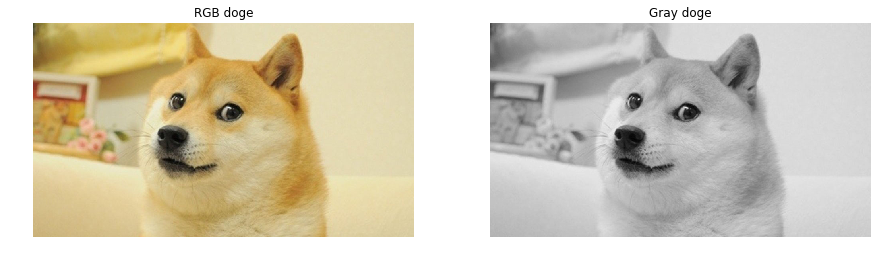

In [2]:
# 輸入彩色圖形並轉成灰階，作範例用

# 彩色轉灰階
def rgb2gray(rgb):
    # reference: https://en.wikipedia.org/wiki/Grayscale#Converting_color_to_grayscale
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

fig, axarr = plt.subplots(1,2,figsize=(15,15))
doge_rgb = np.asarray(mpimg.imread("doge.jpg"))[np.newaxis,:,:,:]
axarr[0].axis('off')
axarr[0].set_title('RGB doge')
axarr[0].imshow(doge_rgb[0])
doge_gray = rgb2gray(doge_rgb)[:,:,:,np.newaxis]
axarr[1].axis('off')
axarr[1].set_title('Gray doge')
axarr[1].imshow(doge_gray[0,:,:,0], cmap = plt.get_cmap('gray'))
print("Shape of doge_rgb =", doge_rgb.shape)
print("Shape of doge_gray =", doge_gray.shape)

## 2. Filter & Convolution

### 2.1 Filter
- 濾波器，亦可稱作kernel或window
- 大小為$f×f×n_C$的矩陣，$f$為filter邊長(通常為奇數)，$n_C$為輸入圖形的channel數量。
- $f$和該卷積層之filter個數$n_f$為該層之超參數(hyperparameters)
- filter矩陣中的每個component都是可被訓練的參數。
<img src="images/filter1.jpg">


### 2.2 Convlution
- 卷積運算: 在輸入圖形上擷取和filter相同大小一張圖形片段，和filter作內積會得到新圖形的一個pixel值，直到將掃過輸入圖形每個地方
- 這裡展示一個有明顯分界線的$5×5×1$輸入圖形對大小為$3×3$的**水平線濾波器**做卷積 (可以在卷積結果圖中發現水平線被抽取出來了)
- CNN架構便是透過多層卷積層的訓練，逐漸抽取出重要的特徵 (e.g.: 在人臉辨識應用當中可能會抽取出五官或是整個臉部)。
- 關於特徵抽取的細節可參考[Sobel Operator@Wikipedia](https://en.wikipedia.org/wiki/Sobel_operator)
<img src="images/edge_detect.gif">
P.S.: 如同機器學習中的$y = wx+b$公式，通常做完卷積後還會加上一個可訓練偏差值$b$。

以下是用程式示範將5x5的垂直和水平濾波器運用在灰階doge圖片上:

In [3]:
def conv_single_step(x_slice_prev, W, b):
    """
    濾波器針對一個大小和濾波器相等的圖形片段做運算
    
    Arguments:
    x_slice_prev: 輸入圖形中要和filter做卷積的片段
    W: filter矩陣, 大小為(f, f, n_C)
    b: 偏差值, 大小為 (1, 1, 1)
    
    Returns:
    Z: 卷積值(W＊x_slice_prev+b)
    """
    s = x_slice_prev * W
    Z = np.sum(s)
    Z = Z + b
    return Z

In [4]:
def filtering(X, W):
    """
    濾波器和輸入圖形做卷積(b=0)
    
    Arguments:
    X: 輸入圖形, 大小為(N, n_H, n_W, n_C)
    W: filter矩陣, 大小為(f, f, n_C)
    
    Returns:
    Z: 輸出圖形, 大小為(N, n_H, n_W, n_C)
    """
    (N, n_H, n_W, n_C) = X.shape
    (f, f) = W.shape
    W = np.repeat(W[:,:,np.newaxis], n_C, axis=2)
    Z = np.zeros((N, n_H-f+1, n_W-f+1, n_C))
    for N_i in range(N):
        for n_h in range(n_H-f+1):
            for n_w in range(n_W-f+1):
                Z[N_i, n_h, n_w] = conv_single_step(X[N_i, n_h:n_h+f, n_w:n_w+f], W, 0)
    Z-=Z.min()
    return Z

水平線Filter為:
 [[ 2  2  2  2  2]
 [ 1  1  1  1  1]
 [ 0  0  0  0  0]
 [-1 -1 -1 -1 -1]
 [-2 -2 -2 -2 -2]] 

垂直線Filter為:
 [[ 2  1  0 -1 -2]
 [ 2  1  0 -1 -2]
 [ 2  1  0 -1 -2]
 [ 2  1  0 -1 -2]
 [ 2  1  0 -1 -2]]


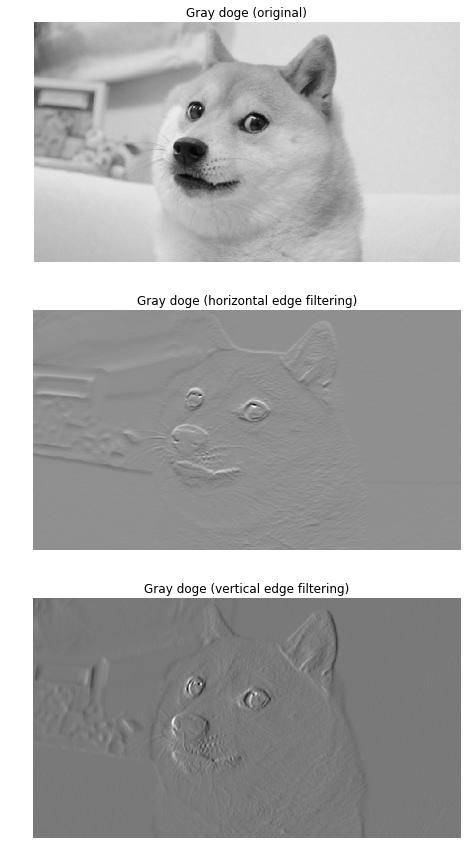

In [5]:
fig, axarr = plt.subplots(3,1,figsize=(15,15))
W_hori_5x5 = np.repeat(np.array([[2,1,0,-1,-2]]).reshape(-1,1), 5, axis=1)  # 水平線濾波器
W_vert_5x5 = np.repeat(np.array([[2,1,0,-1,-2]]), 5, axis=0)                # 垂直線濾波器
doge_gray_hori_filter = filtering(doge_gray, W_hori_5x5)
doge_gray_vert_filter = filtering(doge_gray, W_vert_5x5)
print("水平線Filter為:\n",W_hori_5x5,"\n")
print("垂直線Filter為:\n",W_vert_5x5)
axarr[0].axis('off')
axarr[0].set_title('Gray doge (original)')
axarr[0].imshow(doge_gray[0,:,:,0], cmap = plt.get_cmap('gray'))
axarr[1].axis('off')
axarr[1].set_title('Gray doge (horizontal edge filtering)')
axarr[1].imshow(doge_gray_hori_filter[0,:,:,0], cmap = plt.get_cmap('gray'))
axarr[2].axis('off')
axarr[2].set_title('Gray doge (vertical edge filtering)')
axarr[2].imshow(doge_gray_vert_filter[0,:,:,0], cmap = plt.get_cmap('gray'))

## 3. Stride
- 指在卷積過程中，filter在輸入圖形上滑移的步伐長度，為可調整的超參數
- 目的: 減少該層卷積層輸出圖形的高和寬，即減少下一層之可訓練參數 ($stride$越大，輸出圖形越小)
- e.g.: 當輸入圖形大小為$5×5$，filter大小為$3×3$，若是作一般卷積($stride=1$)則輸出圖形為$3×3$，但若$stride=2$則輸出圖形為$2×2$

<img src="http://deeplearning.net/software/theano/_images/no_padding_strides.gif">

(圖片來源: [Theano官方說明](http://deeplearning.net/software/theano/tutorial/conv_arithmetic.html))

## 4. Zero-padding
- 在圖片四周補上數層零的做法，補上層數為可調整的超參數
- Zero-padding效果(1):
    - 若直接輸入圖形進行卷積
        * 可以發現**圖片四周圍被filter掃過的次數會較圖片中央少，圖片上四個角落被掃過的次數又更少**
        * $\rightarrow$位在圖片四周圍的特徵可能會難以被CNN演算法擷取下來參考
    - 在卷積前先將輸入圖形作Zero-padding
        * 讓被參考次數較少的位置盡量被這些0取代，增加圖片四周圍的特徵被參考到的次數
- Zero-padding效果(2):
    - 當卷積層數量越來越多時，每層的輸出圖形形狀應該是越趨細長的($n_W$和$n_H$減少而$n_C$增加)，padding可防止每層輸出圖形大小快速下降

In [6]:
def zero_pad(X, pad):
    """
    將輸入圖形做zero padding
    
    Argument:
    X: 輸入圖片(numpy array)
    pad: 要padding的數量
    
    Returns:
    X_pad: 已padding過的圖形(numpy array)
    """
    X_pad = np.pad(X, ((0, ),(pad, ), (pad, ), (0, )), 'constant', constant_values=(0, 0))
    return X_pad

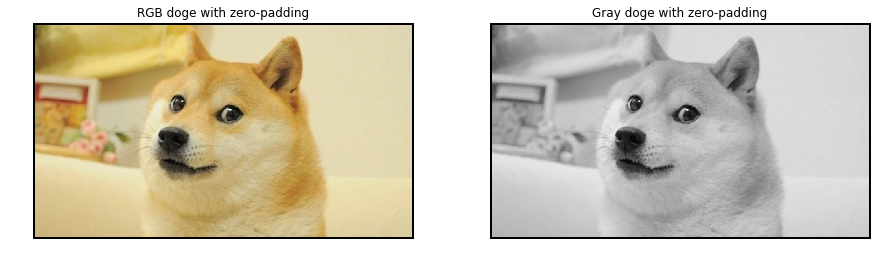

In [7]:
pad = 5 # pad數量
fig, axarr = plt.subplots(1,2,figsize=(15,15))
axarr[0].axis('off')
axarr[0].set_title('RGB doge with zero-padding')
axarr[0].imshow(zero_pad(doge_rgb, pad)[0])
axarr[1].axis('off')
axarr[1].set_title('Gray doge with zero-padding')
axarr[1].imshow(zero_pad(doge_gray, pad)[0,:,:,0], cmap = plt.get_cmap('gray'))


## 5. Pooling
* 譯作池化層，即在一方陣內選取最大值(Max Pooling)或算出平均值(Average Pooling)來當作輸出
* Pooling大小亦為可調整之超參數
* Pooling效果:
    1. 減少輸出圖形大小(減少下一層可訓練參數數量)的手段
    2. 減少overfitting的可能
    3. 讓模型更不會受到圖形誤差(或distortion)影響
* 過去研究亦有提出過方陣範圍重疊的Overlapping Pooling，但效果並不佳，目前大多使用pooling範圍不重疊的方式(如下圖)
<img src="images/pooling.jpg">


## 6. 整理
前面為了方便解釋而稍微調動了調整卷積層的思考順序，故在此重新整理一遍:
1. 輸入圖形大小為$n_H×n_W×n_C$
2. 設定padding層數超參數
3. 設定filter超參數: filter大小$f×f$ (filter厚度等於輸入圖形channel數$n_C$)以及filter個數$n_f$
4. 卷積運算: 設定stride超參數
5. 此時輸出圖形大小:
$$ n_H' = \lfloor \frac{n_{H} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_W' = \lfloor \frac{n_{W} - f + 2 \times pad}{stride} \rfloor +1 $$
$$ n_C' = n_f $$
6. 該層可訓練參數(trainable coefficients)個數為 $(f×f+1)×n_C$ 
    * 含偏差值$b$故$+1$
    * 可訓練參數數量為判斷該如何調整的依據之一
7. 決定是否使用Pooling進一步減少輸出圖形大小: 
    * 設定要用何種pooling和pooling範圍大小
    * pooling大小通常為$2×2$ $\rightarrow$輸出圖形寬和高減半

## 7. Reference
1. DOGE
2. [Deeplearning.ai@Coursera](https://www.coursera.org/specializations/deep-learning)
